In [1]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.4 MB/s eta 0:00:00


# FER 2013 Class Indices
Class0:- Angry \\
Class1:- Disgust \\
Class2:- Fear \\
Class3:- Happy \\
Class4:- Sad \\
Class5:- Surprise \\
Class7:- Neurtal \\

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


unet/config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/456M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/512 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

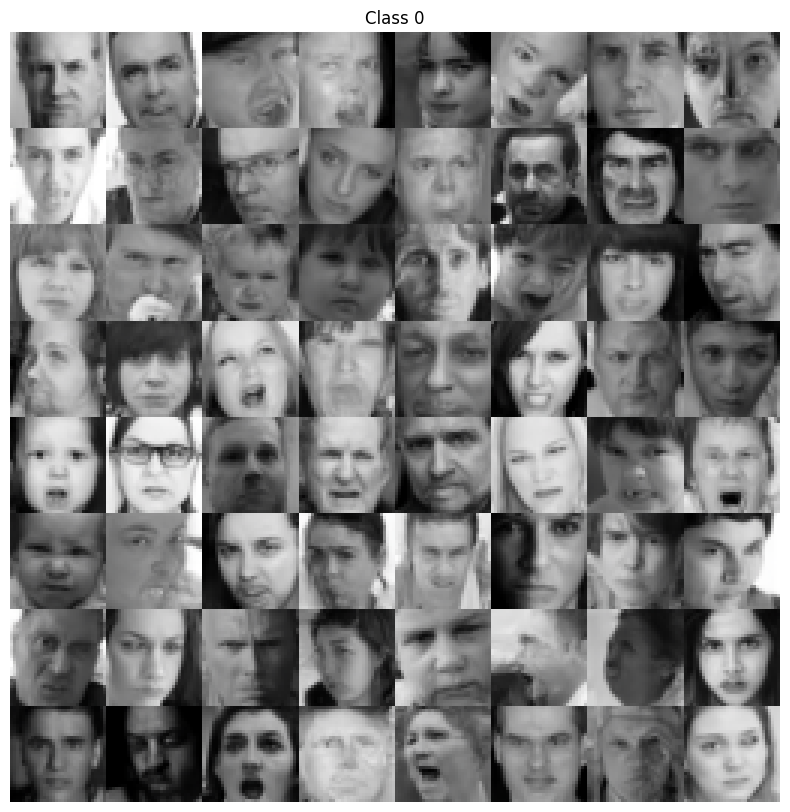

  0%|          | 0/1000 [00:00<?, ?it/s]

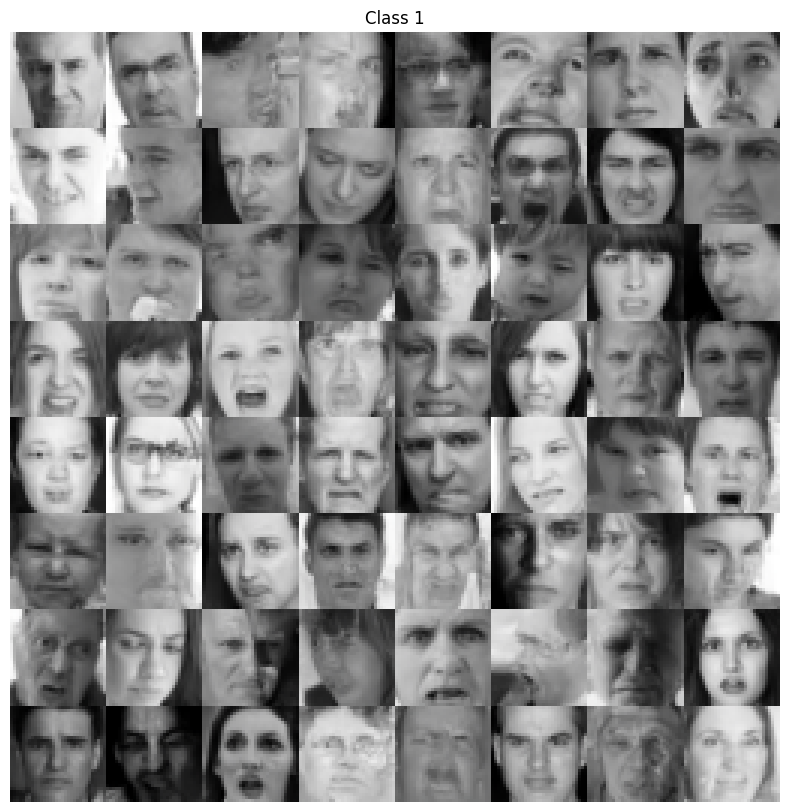

  0%|          | 0/1000 [00:00<?, ?it/s]

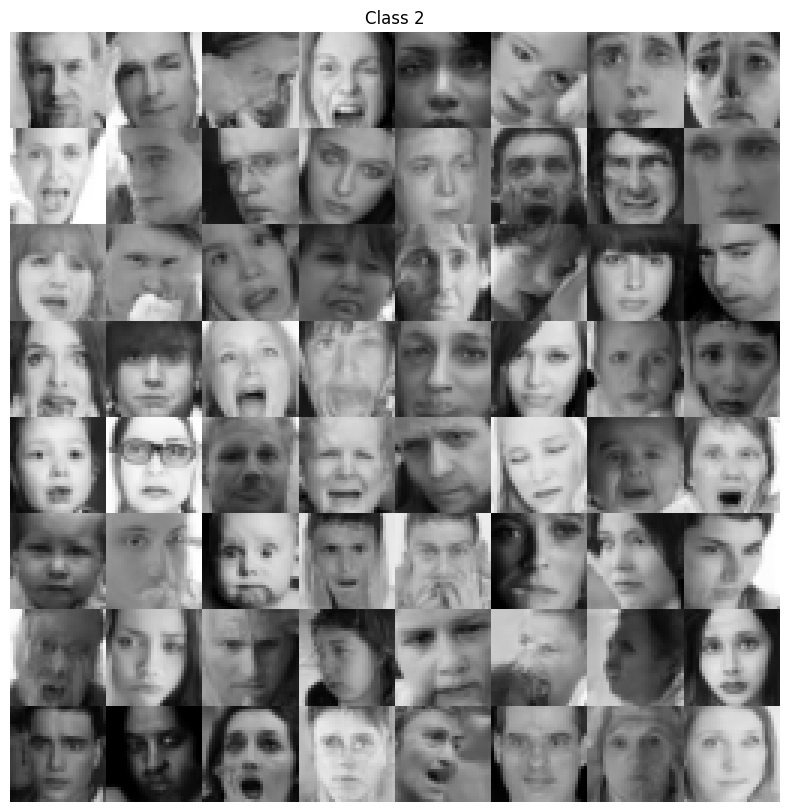

  0%|          | 0/1000 [00:00<?, ?it/s]

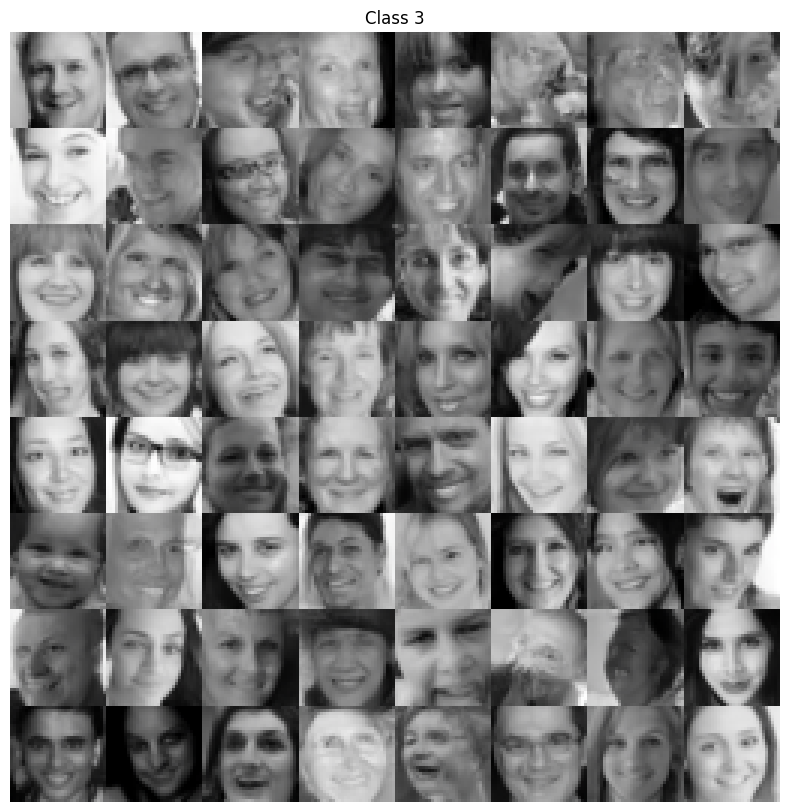

  0%|          | 0/1000 [00:00<?, ?it/s]

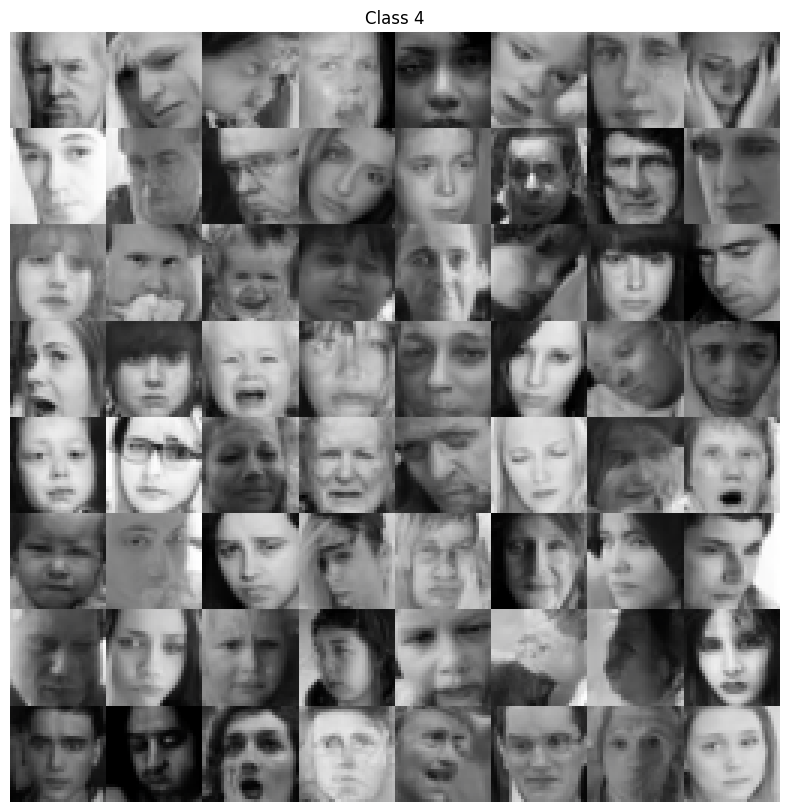

  0%|          | 0/1000 [00:00<?, ?it/s]

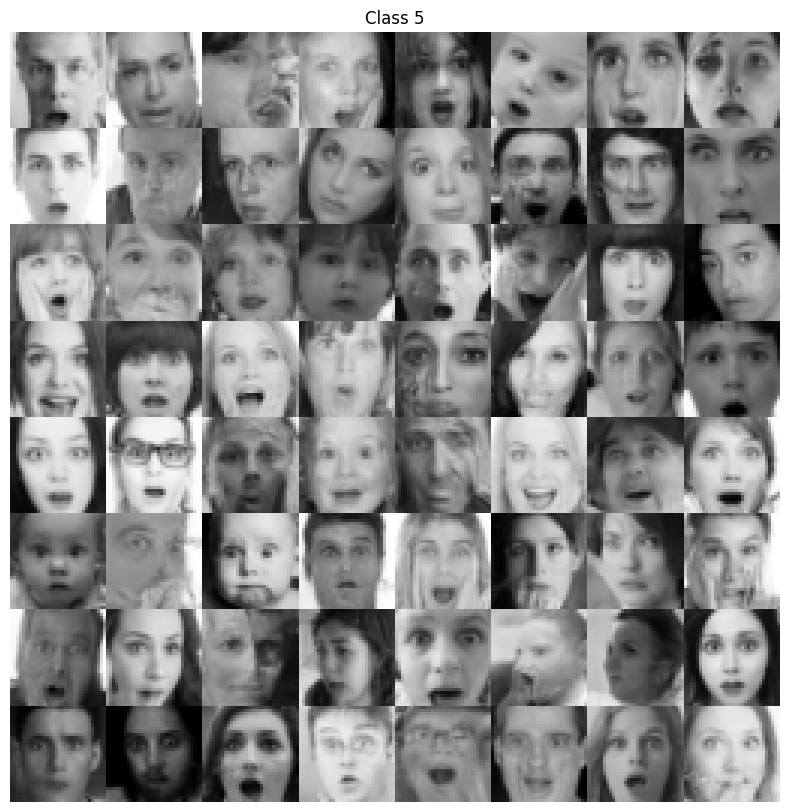

  0%|          | 0/1000 [00:00<?, ?it/s]

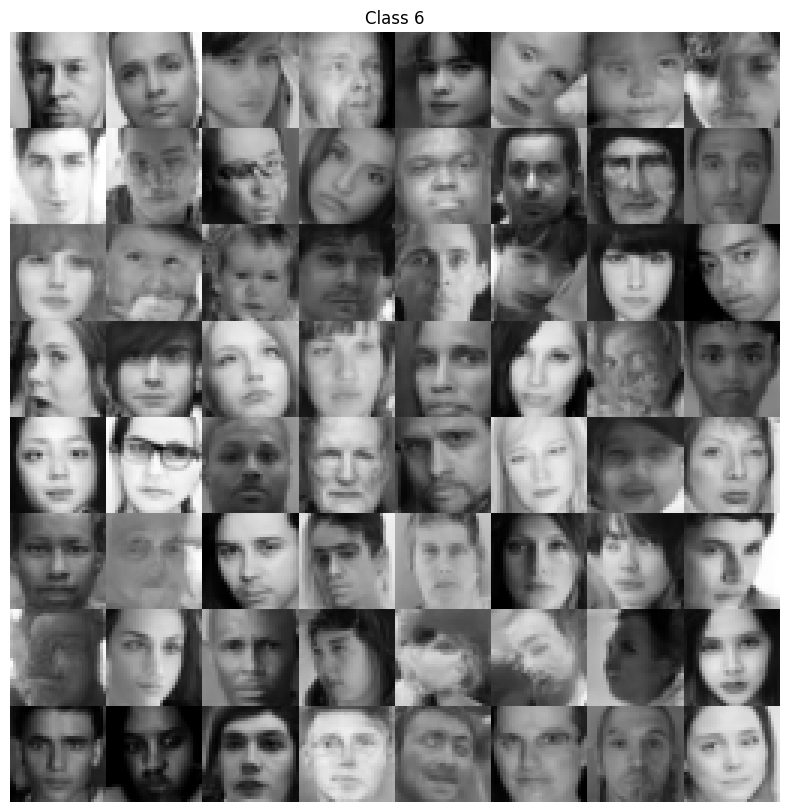

In [2]:
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from huggingface_hub import hf_hub_download
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Union

class DDPMPipelinenew(DiffusionPipeline):
    def __init__(self, unet, scheduler, num_classes: int):
        super().__init__()
        self.register_modules(unet=unet, scheduler=scheduler)
        self.num_classes = num_classes
        self._device = unet.device  # Ensure the pipeline knows the device

    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 64,
        class_labels: Optional[torch.Tensor] = None,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 1000,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:

        # Ensure class_labels is on the same device as the model
        class_labels = class_labels.to(self._device)
        if class_labels.ndim == 0:
            class_labels = class_labels.unsqueeze(0).expand(batch_size)
        else:
            class_labels = class_labels.expand(batch_size)

        # Sample gaussian noise to begin loop
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)

        image = randn_tensor(image_shape, generator=generator, device=self._device)

        # Set step values
        self.scheduler.set_timesteps(num_inference_steps)

        for t in self.progress_bar(self.scheduler.timesteps):
            # Ensure the class labels are correctly broadcast to match the input tensor shape
            model_output = self.unet(image, t, class_labels).sample

            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

    def to(self, device: torch.device):
        self._device = device
        self.unet.to(device)
        return self

def load_pipeline(repo_id, num_classes, device):
    unet = UNet2DModel.from_pretrained(repo_id, subfolder="unet").to(device)
    scheduler = DDPMScheduler.from_pretrained(repo_id, subfolder="scheduler")
    pipeline = DDPMPipelinenew(unet=unet, scheduler=scheduler, num_classes=num_classes)
    return pipeline.to(device)  # Move the entire pipeline to the device

def save_images_locally(images, save_dir, epoch, class_label):
    os.makedirs(save_dir, exist_ok=True)
    for i, image in enumerate(images):
        image_path = os.path.join(save_dir, f"image_epoch{epoch}_class{class_label}_idx{i}.png")
        image.save(image_path)

def generate_images(pipeline, class_label, batch_size, num_inference_steps, save_dir, epoch):
    generator = torch.Generator(device=pipeline._device).manual_seed(0)
    class_labels = torch.tensor([class_label] * batch_size).to(pipeline._device)
    images = pipeline(
        generator=generator,
        batch_size=batch_size,
        num_inference_steps=num_inference_steps,
        class_labels=class_labels,
        output_type="pil",
    ).images
    save_images_locally(images, save_dir, epoch, class_label)
    return images

def create_image_grid(images, grid_size, save_path):
    total_images = grid_size ** 2
    if len(images) < total_images:
        padding_images = total_images - len(images)
        images += [Image.new('RGB', images[0].size)] * padding_images  # Pad with blank images

    width, height = images[0].size
    grid_img = Image.new('RGB', (grid_size * width, grid_size * height))

    for i, image in enumerate(images):
        x = i % grid_size * width
        y = i // grid_size * height
        grid_img.paste(image, (x, y))

    grid_img.save(save_path)
    return grid_img

if __name__ == "__main__":
    repo_id = "Ketansomewhere/King"
    num_classes = 7  # Adjust to your number of classes
    batch_size = 64
    num_inference_steps = 1000  # Can be as low as 50 for faster generation
    save_dir = "generated_images"
    epoch = 0
    grid_size = 8  # 8x8 grid

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pipeline = load_pipeline(repo_id, num_classes, device)

    for class_label in range(num_classes):
        images = generate_images(pipeline, class_label, batch_size, num_inference_steps, save_dir, epoch)

        # Create and save the grid image
        grid_img_path = os.path.join(save_dir, f"grid_image_class{class_label}.png")
        grid_img = create_image_grid(images, grid_size, grid_img_path)

        # Plot the grid image
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img)
        plt.axis('off')
        plt.title(f'Class {class_label}')
        plt.savefig(os.path.join(save_dir, f"grid_image_class{class_label}.png"))
        plt.show()


# Class Index for CIFAR10

airplane - index0

automobile - index1

bird - index2

cat - index3

deer - index4

dog - index5

frog - index6

horse - index7

ship - index8

truck - index9

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


unet/config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/456M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/512 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

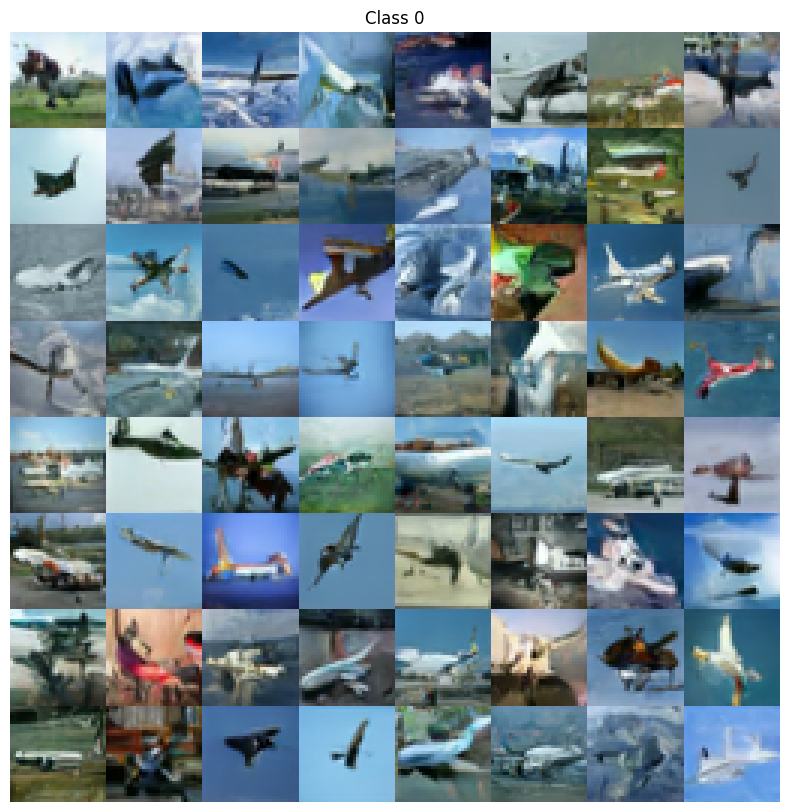

  0%|          | 0/1000 [00:00<?, ?it/s]

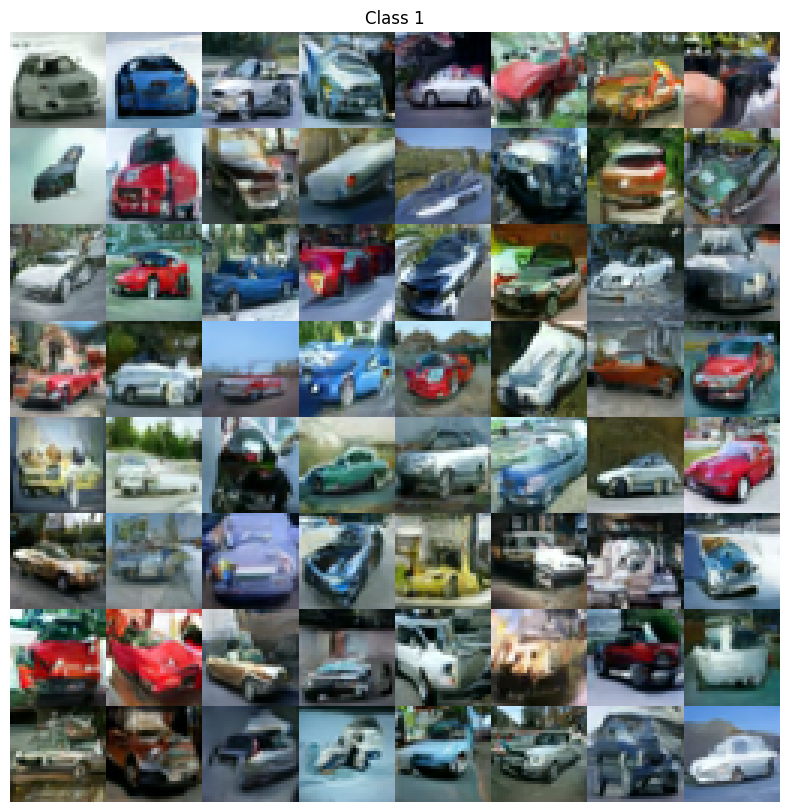

  0%|          | 0/1000 [00:00<?, ?it/s]

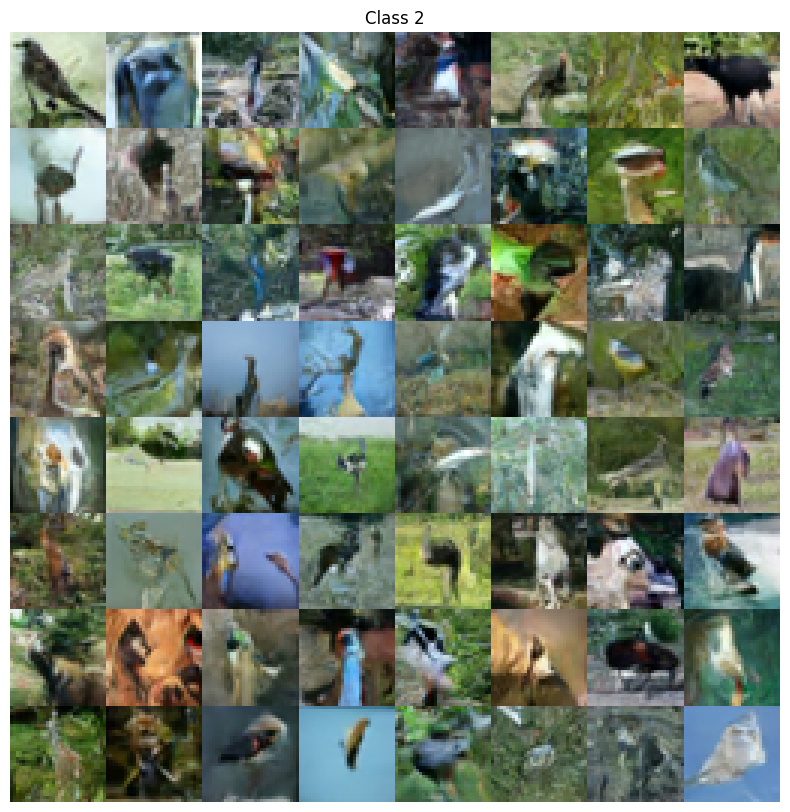

  0%|          | 0/1000 [00:00<?, ?it/s]

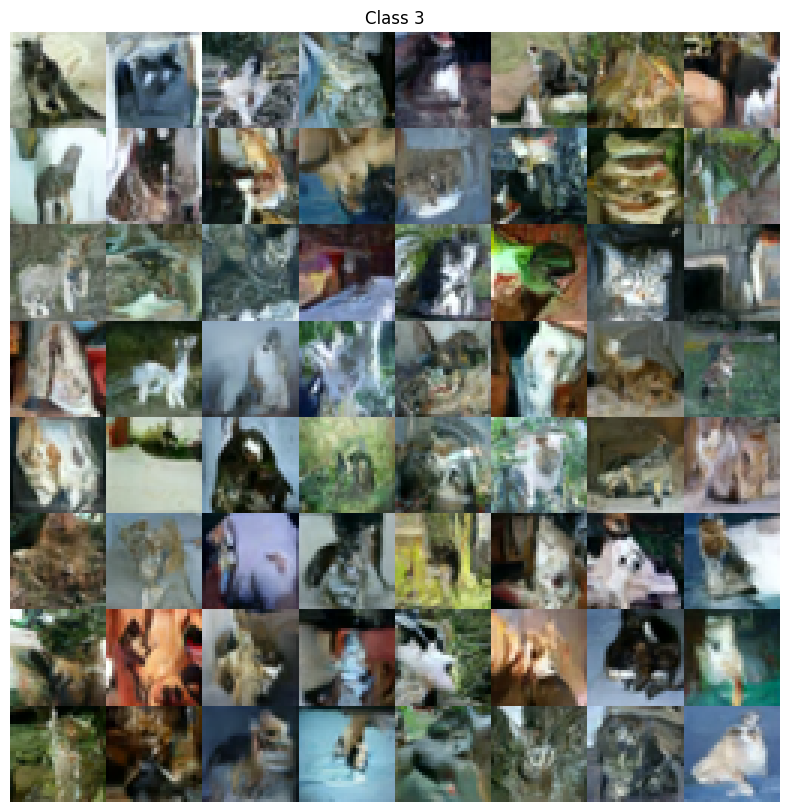

  0%|          | 0/1000 [00:00<?, ?it/s]

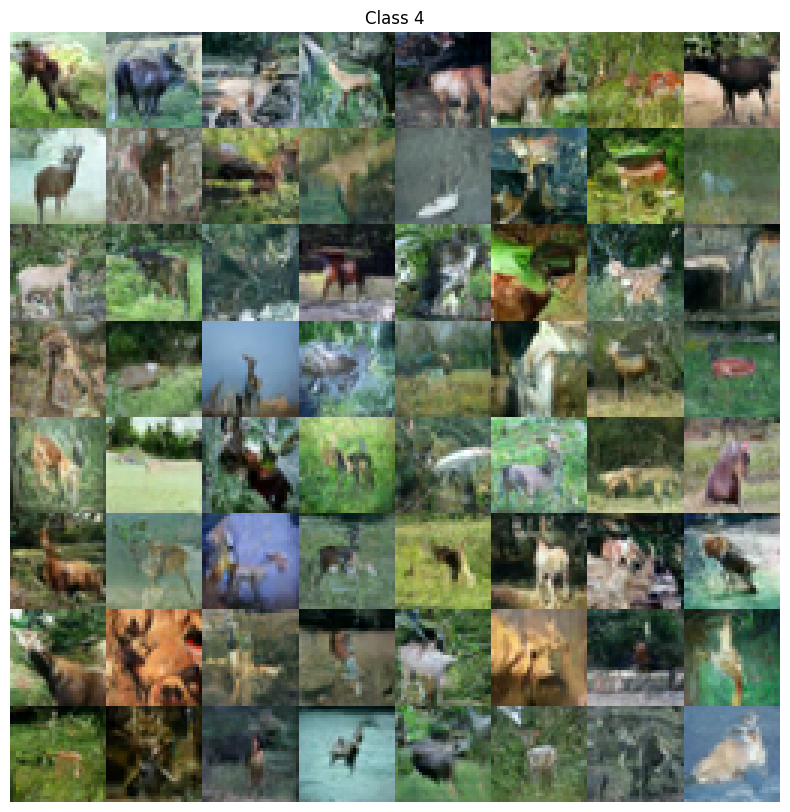

  0%|          | 0/1000 [00:00<?, ?it/s]

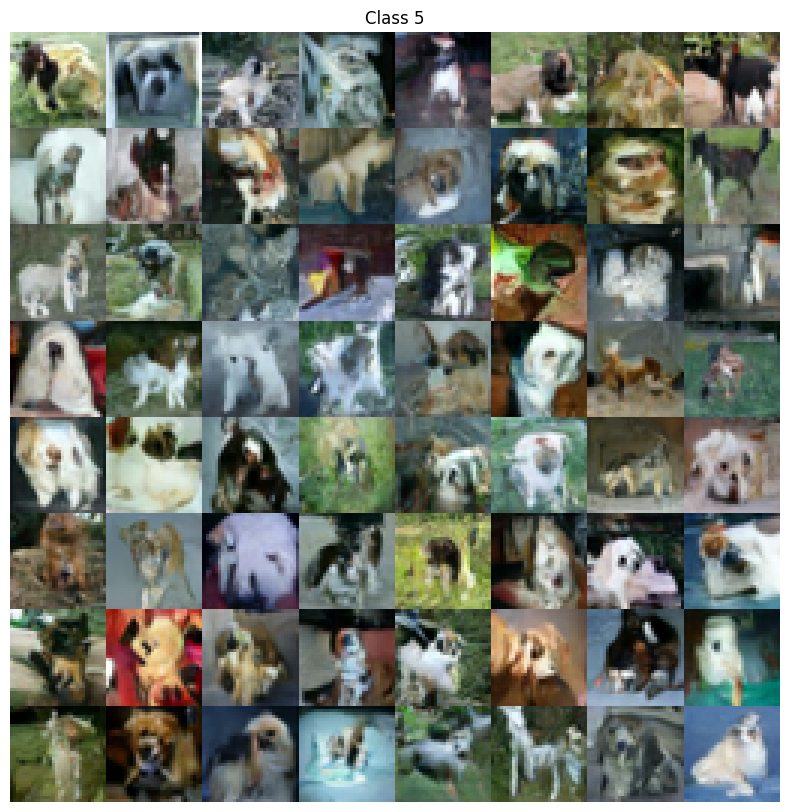

  0%|          | 0/1000 [00:00<?, ?it/s]

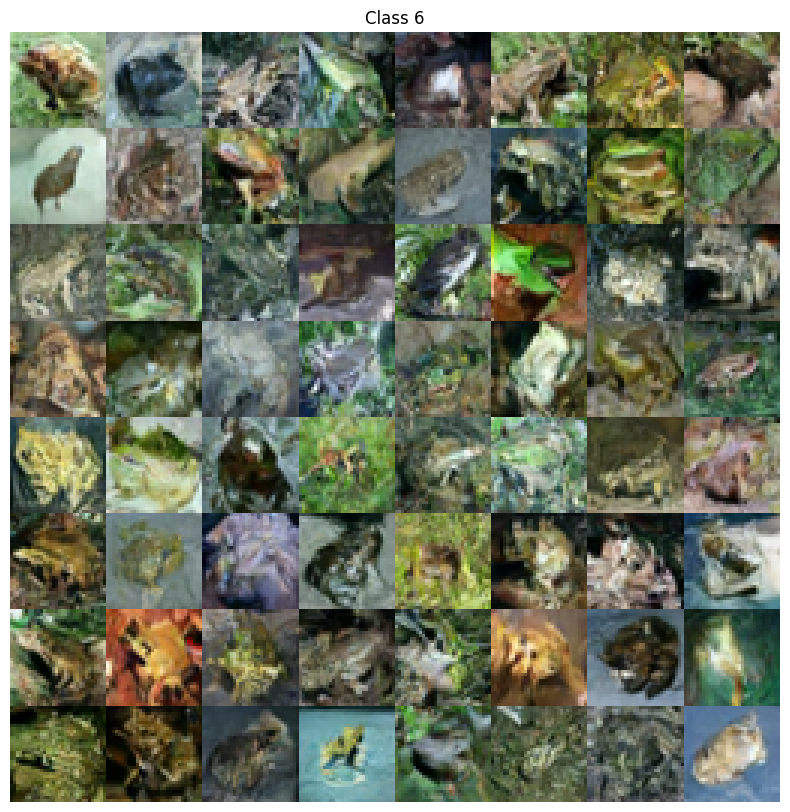

  0%|          | 0/1000 [00:00<?, ?it/s]

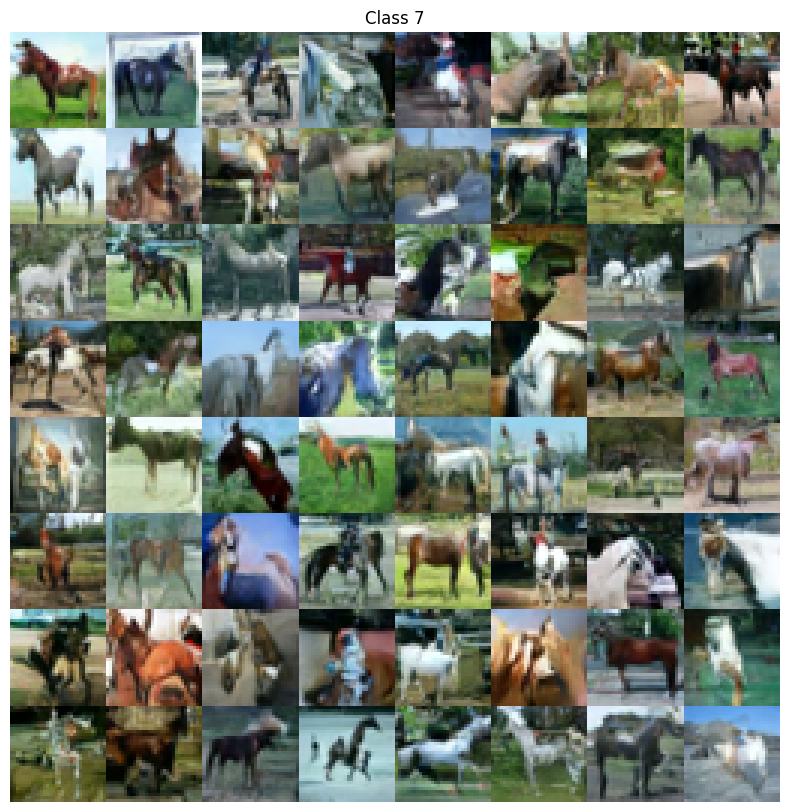

  0%|          | 0/1000 [00:00<?, ?it/s]

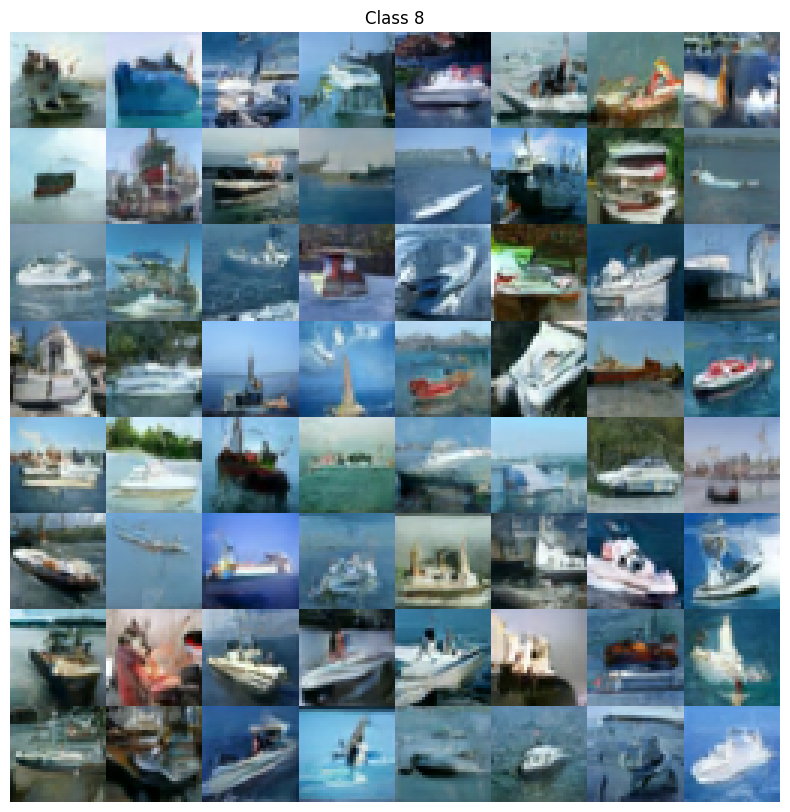

  0%|          | 0/1000 [00:00<?, ?it/s]

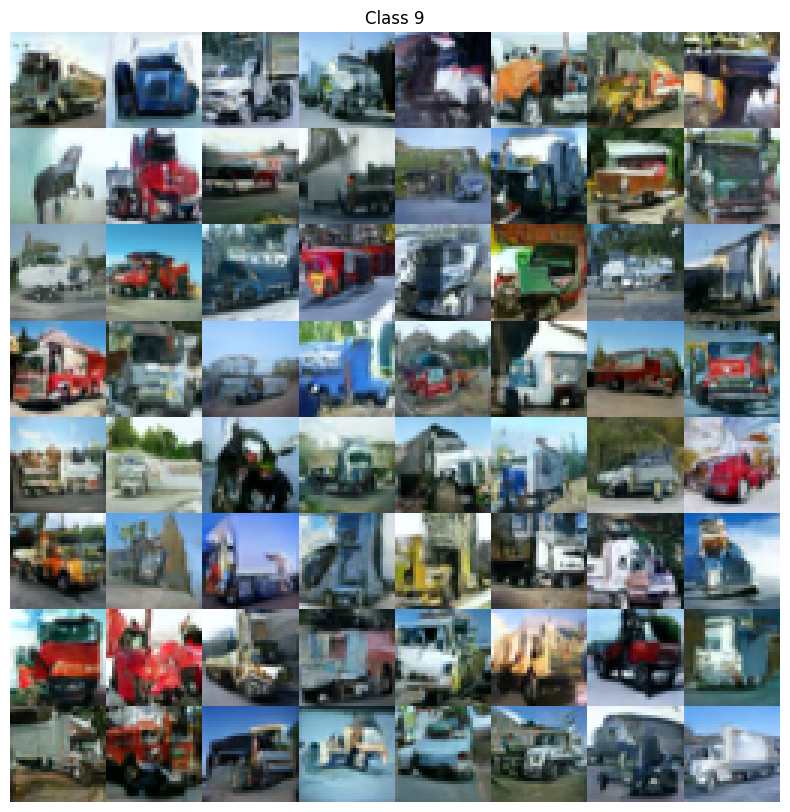

In [3]:
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from huggingface_hub import hf_hub_download
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Union

class DDPMPipelinenew(DiffusionPipeline):
    def __init__(self, unet, scheduler, num_classes: int):
        super().__init__()
        self.register_modules(unet=unet, scheduler=scheduler)
        self.num_classes = num_classes
        self._device = unet.device  # Ensure the pipeline knows the device

    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 64,
        class_labels: Optional[torch.Tensor] = None,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 1000,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:

        # Ensure class_labels is on the same device as the model
        class_labels = class_labels.to(self._device)
        if class_labels.ndim == 0:
            class_labels = class_labels.unsqueeze(0).expand(batch_size)
        else:
            class_labels = class_labels.expand(batch_size)

        # Sample gaussian noise to begin loop
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)

        image = randn_tensor(image_shape, generator=generator, device=self._device)

        # Set step values
        self.scheduler.set_timesteps(num_inference_steps)

        for t in self.progress_bar(self.scheduler.timesteps):
            # Ensure the class labels are correctly broadcast to match the input tensor shape
            model_output = self.unet(image, t, class_labels).sample

            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

    def to(self, device: torch.device):
        self._device = device
        self.unet.to(device)
        return self

def load_pipeline(repo_id, num_classes, device):
    unet = UNet2DModel.from_pretrained(repo_id, subfolder="unet").to(device)
    scheduler = DDPMScheduler.from_pretrained(repo_id, subfolder="scheduler")
    pipeline = DDPMPipelinenew(unet=unet, scheduler=scheduler, num_classes=num_classes)
    return pipeline.to(device)  # Move the entire pipeline to the device

def save_images_locally(images, save_dir, epoch, class_label):
    os.makedirs(save_dir, exist_ok=True)
    for i, image in enumerate(images):
        image_path = os.path.join(save_dir, f"image_epoch{epoch}_class{class_label}_idx{i}.png")
        image.save(image_path)

def generate_images(pipeline, class_label, batch_size, num_inference_steps, save_dir, epoch):
    generator = torch.Generator(device=pipeline._device).manual_seed(0)
    class_labels = torch.tensor([class_label] * batch_size).to(pipeline._device)
    images = pipeline(
        generator=generator,
        batch_size=batch_size,
        num_inference_steps=num_inference_steps,
        class_labels=class_labels,
        output_type="pil",
    ).images
    save_images_locally(images, save_dir, epoch, class_label)
    return images

def create_image_grid(images, grid_size, save_path):
    assert len(images) == grid_size ** 2, "Number of images must be equal to grid_size squared"
    width, height = images[0].size
    grid_img = Image.new('RGB', (grid_size * width, grid_size * height))

    for i, image in enumerate(images):
        x = i % grid_size * width
        y = i // grid_size * height
        grid_img.paste(image, (x, y))

    grid_img.save(save_path)
    return grid_img

if __name__ == "__main__":
    repo_id = "Ketansomewhere/cifar10_conditional_diffusion1"
    num_classes = 10  # Adjust to your number of classes
    batch_size = 64
    num_inference_steps = 1000  # Can be as low as 50 for faster generation
    save_dir = "generated_images"
    epoch = 0
    grid_size = 8  # 8x8 grid

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pipeline = load_pipeline(repo_id, num_classes, device)

    for class_label in range(num_classes):
        images = generate_images(pipeline, class_label, batch_size, num_inference_steps, save_dir, epoch)

        # Create and save the grid image
        grid_img_path = os.path.join(save_dir, f"grid_image_class{class_label}.png")
        grid_img = create_image_grid(images, grid_size, grid_img_path)

        # Plot the grid image
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img)
        plt.axis('off')
        plt.title(f'Class {class_label}')
        plt.savefig(os.path.join(save_dir, f"grid_image_class{class_label}.png"))
        plt.show()
